In [20]:
from common import *
from search.imports import *
from search.search import *
from search.manager import ModelManager
from features.bank import TP

from features import Features
import scipy as sp

In [21]:
import globals as top_imports
top_imports.use_M = False
from given import *

In [22]:
#F, P = pd.read_pickle(big_data/'saves/train_5fixedsince+2.32.pkl')
#setup_P(F=F,P=P)
bigF = Features()

# gotta define some stuff

In [23]:
def get_name(q):
    return q[q.index('<')+1:q.index('>')]

In [24]:
@njit
def sharpe(x):
    mean = x.mean()
    std = x.std()
    std = std if std != 0 else 1.
    return mean/std

In [25]:
quarter = lambda time: (lambda time: (time.dt.year+(time.dt.quarter-1)/4).astype(np.float32))(pd.Series(time))
halfYear = lambda time: (quarter(time)*2).astype(int).values/2

In [26]:
TIME = O(lo=np.datetime64('2009-01-02T22:00:00.000000000'),hi=np.datetime64('2016-12-30T22:00:00.000000001'))
HALFYEAR = O(lo=2009.,hi=2017.)

@njit
def in_interval(x, lo, hi):
    return (lo<=x)&(x<hi)
    #return True if lo==None and hi==None else x<hi if lo is None else lo<=x if hi is None else (lo<=x)&(x<hi)

@njit
def make_blocks(values, lo, hi, get_values=True):
    '''Return [] of (start,end(excl)) indices of blocks of same values in `values`'''
    ans = []
    if get_values:
        ret = []
    i = 0
    prev_x = values[0]
    for i,x in enumerate(values):
        if i==0:
            start = i
            prev_x = x
        elif prev_x!=x:
            if in_interval(prev_x,lo,hi):
                ans.append((start,i))
                if get_values:
                    ret.append(prev_x)
            start = i
            prev_x = x
    if in_interval(prev_x,lo,hi):
        ans.append((start,len(values)))
        if get_values:
            ret.append(prev_x)
    return (ans,ret)# if get_values else ans

@njit
def blocks_sharpe(blocks, values):
    return [sharpe(values[i:j]) for i,j in blocks]

@njit
def mean_blocks_sharpe(blocks, values):
    return np.array([sharpe(values[i:j]) for i,j in blocks]).mean()

score = mean_blocks_sharpe

# @njit # mean blocks
# def cv_ho_scores(blocks, values):
#     return mean_blocks_sharpe(blocks[2:-3],values), mean_blocks_sharpe(blocks[-3:],values) #CVHO

@njit
def cv_ho_scores(blocks, values):
    return sharpe(values[blocks[2][0]:blocks[-3][0]]), sharpe(values[blocks[-3][0]:]) #CVHO

In [27]:
@njit
def blocks_sum(blocks, values):
    return np.array([values[i:j].sum() for i,j in blocks])

@njit
def tanh_trans(a, shrink):
    '''transform `a` by tanh centered at `a.mean()` with shrink factor `shrink`'''
    center = a.mean()
    return np.tanh((a-center) * shrink) + center

@njit
def linear_isotonic(a, joints):
    n = len(joints) - 1 # number of segments (there is a joint at both endpoints)
    b = np.zeros(a.shape, dtype=a.dtype)
    for i, x in enumerate(a):
        k = binary_search_right(joints, x) - 1
        b[i] = (k / n + (x-joints[k]) / (joints[k+1]-joints[k]) / n) * 2 - 1
    return b

@njit
def lin_iso(a, joints):
    center = a.mean()
    return linear_isotonic(a-center, joints) + center

@njit
def make_joints(weights):
    joints = np.cumsum(weights * 2.) - 1.
    assert abs(1. - joints[-1]) < 1e-6, '[in `make_joints`] weights don\'t sum to 1'
    joints[-1] = 1.
    joints = np.concatenate((np.array([-1.]), joints), axis=0)
    return joints

@njit
def daily(blocks, x, y):
    xy = x * y
    return np.array([xy[i:j].sum() for i,j in blocks])

@njit
def daily_tt(blocks, x, y, shrink):
    return np.array([(tanh_trans(x[i:j], shrink) * y[i:j]).sum() for i,j in blocks])

@njit
def daily_li(blocks, x, y, weights):
    joints = make_joints(weights)
    return np.array([(lin_iso(x[i:j], joints) * y[i:j]).sum() for i,j in blocks])

In [28]:
def change_index(func=None, name=None):
    #assert not func is None and name is None, '`change_index` must either change index or the name!'
    if func is None:
        func = lambda x: x
    def change(x):
        x.index = func(x.index)
        if name is not None:
            x.index.name = name
        return x
    return change

# def make_sharpes_function(lo=None, hi=None): # blocks of sharpe
#     lo = lo if lo is not None else HALFYEAR.lo
#     hi = hi if hi is not None else HALFYEAR.hi
#     def sharpes(x, *, group=None, blocks=None):
#         group_name = group.name if hasattr(group, 'name') else 'halfYear'
#         if blocks is not None:
#             pass
#         elif group is not None and not isinstance(group, np.ndarray):
#             group = group.values
#         elif group is None:
#             group = halfYear(x.index)
        
#         if not isinstance(x, np.ndarray):
#             x = x.values
            
#         if blocks is None:
#             blocks, block_values = make_blocks(group, lo=lo, hi=hi, get_values=True)
            
#         data = blocks_sharpe(blocks, x)
        
#         return pd.Series(data, index=block_values).pipe(change_index(name=group_name))
#     return sharpes
# #CVHO
# cv = make_sharpes_function(lo=2010.,hi=2015.5)
# ho = make_sharpes_function(lo=2015.5)

def make_sharpe_function(lo=None, hi=None):
    lo = lo if lo is not None else HALFYEAR.lo
    hi = hi if hi is not None else HALFYEAR.hi
    def sharpe(x, *, group=None):
        group_name = group.name if hasattr(group, 'name') else 'halfYear'
        if group is not None and not isinstance(group, np.ndarray):
            group = group.values
        elif group is None:
            group = halfYear(x.index)
        
        if not isinstance(x, np.ndarray):
            x = x.values
        
        data = x[(lo<=group)&(group<hi)]
        std = data.std(ddof=0)
        return data.mean()/std if std!=0 else 0.
    return sharpe
#CVHO
cv = make_sharpe_function(lo=2010.,hi=2015.5)
ho = make_sharpe_function(lo=2015.5)

### set the models to blend

In [215]:
q_ = q_flat = [] # flat
q_ += [getattr(TP,x) for x in 'IKGHomo IKGHomoTenDraw'.split()]
q_ += [getattr(TP,x) for x in 'Global IKGZenThreeMoreShort'.split()]
q_ += [getattr(TP,x) for x in 's20 s21 s00 s10'.split()]
q_ += [getattr(TP,x) for x in 'TryIt'.split()]

q_ = q_vp10 = [] # vp10
q_ += [getattr(TP,x) for x in 'ikg IKGZenVolatility'.split()]
q_ += [getattr(TP,x) for x in 's20 s21 s22 s00 s10 s11'.split()]
q_ += [getattr(TP,x) for x in 'TryIt'.split()]

# q_ = []
# q_ += [getattr(TP,x) for x in 'ikg IKGZen IKGHomo IKGZenTenDraw IKGHomoTenDraw IKGZenVolatility IKGHomoVolatility'.split()]
# q_ += [getattr(TP,x) for x in 'Another Global IKGHomoThree IKGZenThree IKGZenThreeVP1 IKGZenThreeMoreShort'.split()]
# q_ += [getattr(TP,x) for x in 's20 s21 s22 s00 s10 s11'.split()]
# q_ += [getattr(TP,x) for x in 'IKGCover TryIt IKGCoverThreeVP1 IKGCoverThreeMoreShort'.split()]
q_ = q_flat = [getattr(TP,x) for x in ['IKGHomoThree']]

In [216]:
# qq_ = []
# qq_ += [TP.PairFiveShortVP1_1_0_0_NoCorr]

# Load up the models

In [217]:
DIR = '/big/data/love2009/'

In [219]:
ans = []
nbests = []

#q_ = q_flat
mm = ModelManager(DIR+'flat')
for q in q_:
    name = get_name(q)
    f, _ = bigF.query_solo(q)
    fi = mm.F.i(Feats=f)
    pm = mm.iPM(fi, 0)
    nbest = pm.get('Results', i=0).nbest
    guy = pm.get('Answers', i=0)
    res = pd.concat([guy[i][0] for i in range(len(guy)-1)]+guy[-1][1:], axis=0)
    ans.append(res)
    nbests.append(nbest)

#q_ = q_vp10
mm = ModelManager(DIR+'vp10')
for q in q_:
    name = get_name(q)
    f, _ = bigF.query_solo(q)
    fi = mm.F.i(Feats=f)
    pm = mm.iPM(fi, 0)
    nbest = pm.get('Results', i=0).nbest
    guy = pm.get('Answers', i=0)
    res = pd.concat([guy[i][0] for i in range(len(guy)-1)]+guy[-1][1:], axis=0)
    ans.append(res)
    nbests.append(nbest)
    
# Pair = O(lo=(.55, 500), hi=None, repeat=2)
# tag = f'pair,{Pair.lo},{Pair.hi},{Pair.repeat}'
# mm = ModelManager(DIR+tag)
# for q in qq_:
#     name = get_name(q)
#     fi = 0
#     pm = mm.iPM(fi, 0)
#     nbest = pm.get('Results', i=0).nbest
#     guy = pm.get('Answers', i=0)
#     res = pd.concat([guy[i][0] for i in range(len(guy)-1)]+guy[-1][1:], axis=0)
#     ans.append(res)
#     nbests.append(nbest)

In [220]:
names = ['a'+get_name(q) for q in q_flat] + ['m'+get_name(q) for q in q_vp10]# + ['p'+get_name(q) for q in qq_]

In [221]:
def get_daily(df):
    WEIGHT = 'flat_weight' if 'flat_weight' in df else 'vp10_weight'
    df['trade'] = (df.target*2-1) * df[WEIGHT] * df.guess.fillna(0)
    return df.groupby('time')[['trade']].sum()

In [222]:
# p = P[P.quarter>=2010]
d = None
my = None
for name, res in zip(names, ans):
    if d is None:
        d = get_daily(res).rename(columns={'trade':name})
        my = res.copy()
        my.rename(columns={'guess':name},inplace=True)
        del my['trade']
    else:
        d[name] = get_daily(res).iloc[:,0]
        my[name] = res.guess
        if 'vp10_weight' in res and 'vp10_weight' not in my:
            my['vp10_weight'] = res.vp10_weight
my['upDown'] = my.target*2-1

buff

tapu bulu

buzzwole

# Exploit what we have

In [193]:
d = e

In [194]:
# paircol = 'pPairFiveShortVP1_1_0_0_NoCorr'
# cols = ['m'+x for x in 's20 s21 s22 s00 s10 s11 IKGCover TryIt IKGCoverTenDraw IKGCoverThreeMoreShort'.split()]
# cols += ['a'+x for x in 's20 s21 s22 s00 s10 s11 IKGCover TryIt IKGCoverTenDraw IKGCoverThreeMoreShort'.split()]
# d = d['ms10 as21 aTryIt aIKGCoverThreeMoreShort'.split() + []]
d = d[
'aGlobal '#'aAnother '
'aTryIt '#1#'aikg '
'as21 as00 '#'as20 as10 as00 '#'as20 '#'as21 as22 as10 as11 '
#'aIKGHomo '#'aIKGHomoVolatility '#'aIKGHomoTenDraw '#'aIKGHomoThree '#'aIKGHomo aIKGHomoVolatility '
#'aIKGZenThreeMoreShort '#'aIKGZenTenDraw 'aIKGZen '#'aIKGZenVolatility ' #'aIKGZenThreeVP1 aIKGZenThreeMoreShort '
# 'aIKGCoverThreeVP1 '#'aIKGCover aTryIt aIKGCoverThreeMoreShort '
#'mGlobal '#'mAnother '
#'mikg '#'mTryIt '
'ms10 '#'ms21 ms20 '#'ms20 '#'as22 as10 as11 '
#'mIKGHomoTenDraw mIKGHomoThree '#'aIKGHomo aIKGHomoVolatility '
#'mIKGZenThreeMoreShort '#'aIKGZenTenDraw 'aIKGZen '#'aIKGZenVolatility ' #'aIKGZenThreeVP1 aIKGZenThreeMoreShort '
#'mIKGCover '#'aTryIt aIKGCoverThreeVP1 aIKGCoverThreeMoreShort '
''.split()]

In [195]:
_DO_IT_ = True

In [196]:
%%time
if _DO_IT_:
    n = 1_000_000
    cc = np.random.exponential(size=(n,d.shape[1]))
    cc /= cc.sum(axis=1)[:,np.newaxis]
    dd = d.values
    blocks, _ = make_blocks(halfYear(d.index.values), HALFYEAR.lo, HALFYEAR.hi)
    scores = [cv_ho_scores(blocks, dd@c) for c in cc]
    ibest = sorted(range(n), key=lambda i: scores[i][0]*13+scores[i][1]*3, reverse=True)
_DO_IT_ = False

CPU times: user 15.1 s, sys: 89.3 ms, total: 15.2 s
Wall time: 15.2 s


In [197]:
list(zip(d.columns, cc[ibest[0]]))

[('aGlobal', 0.049096501566732037),
 ('aTryIt', 0.17406341678455212),
 ('as21', 0.22114831667041474),
 ('as00', 0.00036814388521853609),
 ('ms10', 0.55532362109308264)]

In [198]:
%matplotlib inline
canvas(18,6)

(0.762196120485743, 0.7078515833324491)


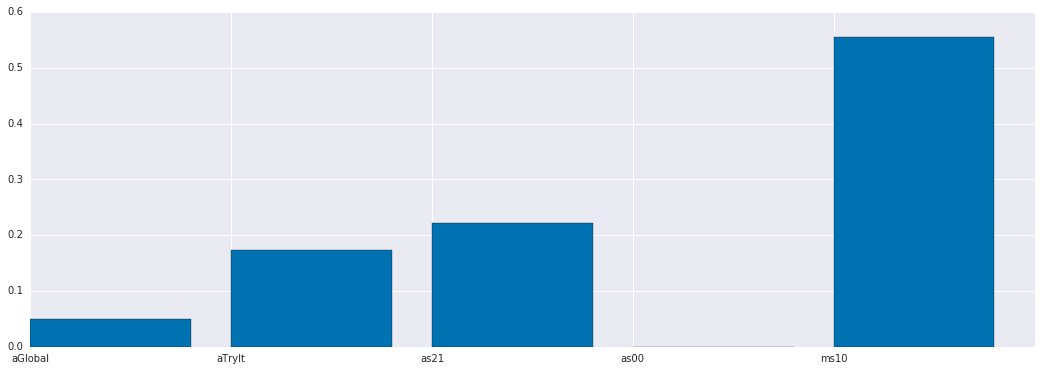

In [202]:
k = 0
print(scores[ibest[k]])
plt.bar(np.arange(d.shape[1]), tick_label=d.columns, height=cc[ibest[k]]);

In [200]:
(0.7843577221117826, 0.6784511641606711)

(0.7843577221117826, 0.6784511641606711)

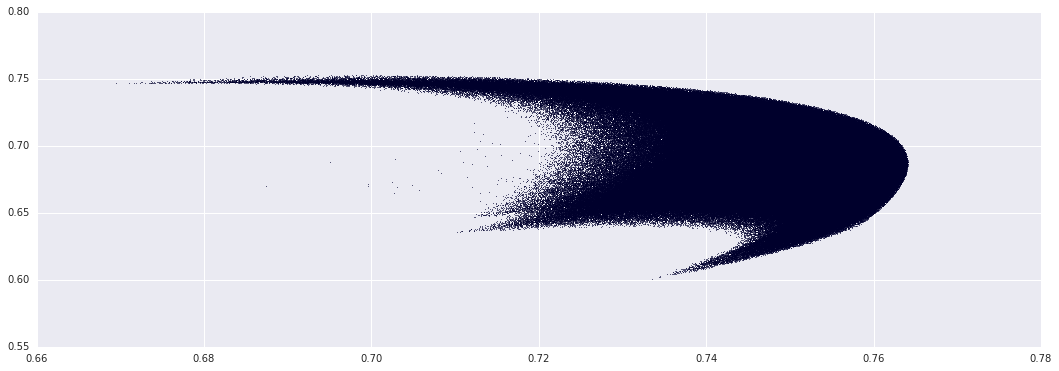

In [201]:
guys = np.asarray([[scores[i][0], scores[i][1]] for i in ibest[::]])
plt.scatter(guys[:,0], guys[:,1], s=.3);

# Hardcore weight optimization

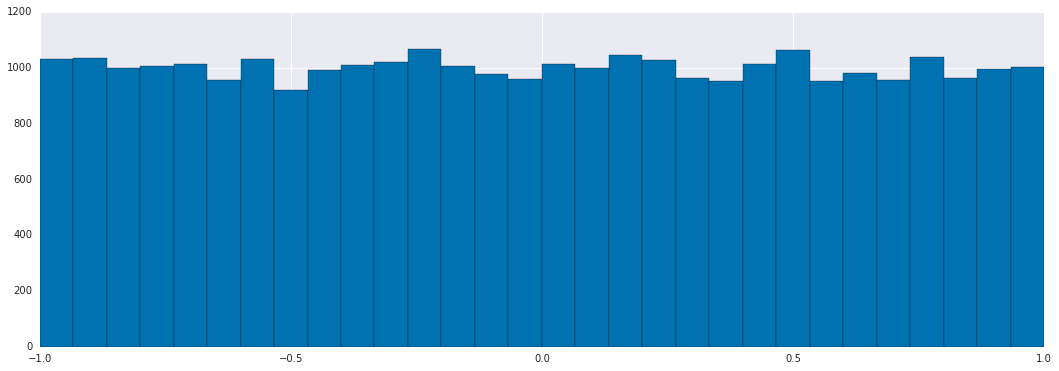

In [228]:
plt.hist(normal.cdf(np.random.normal(size=30000))*2-1, bins=30);

In [108]:
check = []
e = None
for name in names:
    my['trade'] = my[name] * my.upDown*(my.flat_weight if name[0]!='m' else my.vp10_weight)
    what = my.groupby('time')[['trade']].sum()
    
    if e is None:
        e = what.rename(columns={'trade':name})
    else:
        e[name] = what.trade
    
    what = what.trade
    scores = [cv(what).mean(), ho(what).mean()]
    check.append(scores + [(scores[0]*13+scores[1]*3)/16])
    print(name, check[-1])
jst = [guy[-1] for guy in check]

aIKGHomo [0.64664307046674807, 0.52883902128587745, 0.62455481124533485]
aIKGHomoTenDraw [0.6453865174324066, 0.52390378729863385, 0.62260850553232427]
aGlobal [0.61796623262897687, 0.50898773224772031, 0.59753276380749121]
aIKGZenThreeMoreShort [0.64687292256942164, 0.53035623920800767, 0.62502604443915644]
as20 [0.55903534765939278, 0.60793704658050929, 0.56820441620710205]
as21 [0.62676902935651624, 0.45989691166471669, 0.59548050728930391]
as00 [0.64144616174113644, 0.5973629061949034, 0.63318055132621776]
as10 [0.63658770457518477, 0.53298123729427127, 0.61716149196001346]
aTryIt [0.61998028484024315, 0.69299145324469702, 0.63366987891607818]
mikg [0.57844585398348813, 0.57921888285499479, 0.57859079689689563]
mIKGZenVolatility [0.58420217098375282, 0.5889189862495251, 0.58508657384608509]
ms20 [0.56949869709257772, 0.53481836653135284, 0.56299613511234803]
ms21 [0.60991451107124806, 0.48257435687155786, 0.58603823215880613]
ms22 [0.618104684321922, 0.59262542114043171, 0.61332732

In [109]:
check = []
e = None
def func(x):
    # return x * len(x) # wtf it's better to extraly weigh the days with more days
    return x / np.sqrt((x**2).sum())
for name in names:
    my['testing'] = my.groupby('time')[name].transform(func)
    my['test'] = my.testing * my.upDown*(my.flat_weight if name[0]!='m' else my.vp10_weight)
    what = my.groupby('time')[['test']].sum()
    
    if e is None:
        e = what.rename(columns={'test':name})
    else:
        e[name] = what.test
    
    what = what.test
    scores = [cv(what).mean(), ho(what).mean()]
    check.append(scores + [(scores[0]*13+scores[1]*3)/16])
    print(name, check[-1])
nrm = [guy[-1] for guy in check]

aIKGHomo [0.68073167851847427, 0.5415965538426869, 0.65464384264176412]
aIKGHomoTenDraw [0.67972792576345831, 0.53059812512031901, 0.65176608814286963]
aGlobal [0.63678949560083953, 0.49820260492263929, 0.61080445359867697]
aIKGZenThreeMoreShort [0.67919746567623507, 0.53755592021762122, 0.65263967590274496]
as20 [0.57185589449487217, 0.64537208583599692, 0.58564018037133303]
as21 [0.66832836550788099, 0.43274794774801201, 0.62415703717790549]
as00 [0.68513386935822951, 0.62329492210897119, 0.67353906674899355]
as10 [0.64614935995792588, 0.54509476444088312, 0.62720162329848028]
aTryIt [0.64172187733810238, 0.72991493570874366, 0.65825807578259754]
mikg [0.60670558819127951, 0.60159839239253521, 0.60574798897901494]
mIKGZenVolatility [0.61699375143107438, 0.60952588495272575, 0.61559352646638399]
ms20 [0.58101875549725768, 0.52756342997245198, 0.57099588196135664]
ms21 [0.63840475655440332, 0.47835790624267388, 0.60839597212095409]
ms22 [0.64177348351402752, 0.63116962423454759, 0.6397

In [111]:
check = []
e = None
def func(x):
    mean = x.mean()
    return np.tanh((x-mean)*7)+mean
for name in names:
    my['testing'] = my.groupby('time')[name].transform(func)
    my['test'] = my.testing * my.upDown*(my.flat_weight if name[0]!='m' else my.vp10_weight)
    what = my.groupby('time')[['test']].sum()
    
    if e is None:
        e = what.rename(columns={'test':name})
    else:
        e[name] = what.test
    
    what = what.test
    scores = [cv(what).mean(), ho(what).mean()]
    check.append(scores + [(scores[0]*13+scores[1]*3)/16])
    print(name, check[-1])
tt7 = [guy[-1] for guy in check]

aIKGHomo [0.69063351634062198, 0.55103046324013727, 0.66445794388428114]
aIKGHomoTenDraw [0.69487388966030605, 0.53247780850368565, 0.66442462444343964]
aGlobal [0.69309831229633723, 0.62695106214894236, 0.68069570289370063]
aIKGZenThreeMoreShort [0.69471015759534127, 0.54655054342765008, 0.66693022993889917]
as20 [0.58698454432946301, 0.67953593850880389, 0.60433793073808939]
as21 [0.70196180093066896, 0.59696314138534423, 0.6822745522659206]
as00 [0.69784792672429241, 0.63416193911304553, 0.68590680404718363]
as10 [0.65791813734635962, 0.58799735049857305, 0.64480798981239973]
aTryIt [0.66064134297094979, 0.73065163907532971, 0.67376827349052104]
mikg [0.59999815264232115, 0.58577639531971615, 0.59733157314433272]
mIKGZenVolatility [0.61059955473892868, 0.60126366214180593, 0.60884907487696815]
ms20 [0.59602446295818801, 0.50175331106002785, 0.57834862197728298]
ms21 [0.63039525002068164, 0.54282382812212826, 0.61397560841470289]
ms22 [0.64799242756882525, 0.60508036591836856, 0.6399

In [117]:
check = []
e = None
def func(x):
    # return x * len(x) # wtf it's better to extraly weigh the days with more days
    fact = x.std()
    mean = x.mean()
    return np.tanh((x-mean)/fact)+mean
    fact = np.sqrt((x**2).sum())
    return x / fact
for name in names:
    my['testing'] = my.groupby('time')[name].transform(func)
    my['test'] = my.testing * my.upDown*(my.flat_weight if name[0]!='m' else my.vp10_weight)
    what = my.groupby('time')[['test']].sum()
    
    if e is None:
        e = what.rename(columns={'test':name})
    else:
        e[name] = what.test
    
    what = what.test
    scores = [cv(what).mean(), ho(what).mean()]
    check.append(scores + [(scores[0]*13+scores[1]*3)/16])
    print(name, check[-1])
tts = [guy[-1] for guy in check]

aIKGHomo [0.70244164060167846, 0.5543970084341624, 0.67468327207026912]
aIKGHomoTenDraw [0.70625345417566798, 0.53736143252134483, 0.67458620011548243]
aGlobal [0.70685176757010537, 0.63569235462220608, 0.69350937764237419]
aIKGZenThreeMoreShort [0.70614808248082084, 0.5530800776275604, 0.67744783157083444]
as20 [0.58909347460477812, 0.69641819056111309, 0.60921685884659094]
as21 [0.7268350750223973, 0.60650030952369405, 0.7042723064913905]
as00 [0.70824933559962966, 0.64178021410879749, 0.69578637532009857]
as10 [0.66181797074208515, 0.59109871452020046, 0.64855811020048182]
aTryIt [0.66373158765114482, 0.74325944052711934, 0.6786430600653901]
mikg [0.60728360131662695, 0.59088951853678695, 0.60420971079540697]
mIKGZenVolatility [0.61960032402492349, 0.60587937863021002, 0.61702764676341459]
ms20 [0.59496180957697575, 0.49666814805207626, 0.57653174804105711]
ms21 [0.64128714644729035, 0.54297619295437782, 0.62285384266736921]
ms22 [0.65551462538363892, 0.61937594389415207, 0.64873862

In [118]:
check = []
e = None
def func(x):
    # return x * len(x) # wtf it's better to extraly weigh the days with more days
    fact = x.std()
    mean = x.mean()
    x = np.tanh((x-mean)/fact)+mean
    fact = np.sqrt((x**2).sum())
    return x / fact
for name in names:
    my['testing'] = my.groupby('time')[name].transform(func)
    my['test'] = my.testing * my.upDown*(my.flat_weight if name[0]!='m' else my.vp10_weight)
    what = my.groupby('time')[['test']].sum()
    
    if e is None:
        e = what.rename(columns={'test':name})
    else:
        e[name] = what.test
    
    what = what.test
    scores = [cv(what).mean(), ho(what).mean()]
    check.append(scores + [(scores[0]*13+scores[1]*3)/16])
    print(name, check[-1])
ssn = [guy[-1] for guy in check]

aIKGHomo [0.7043217127530611, 0.55616579148426626, 0.67654247751516206]
aIKGHomoTenDraw [0.70857148106265322, 0.5394852641702319, 0.67686781539532426]
aGlobal [0.70625657027833277, 0.63449142155531046, 0.69280060489276607]
aIKGZenThreeMoreShort [0.70757552568974758, 0.55482774983731753, 0.678935317717417]
as20 [0.58949965280594419, 0.70026728669968807, 0.61026858416102114]
as21 [0.73018163195655461, 0.60393240752907129, 0.70650990237640143]
as00 [0.70908651795583766, 0.64454195781626711, 0.69698441292966828]
as10 [0.66140784136654296, 0.59161004875647616, 0.64832075525215538]
aTryIt [0.66418395206310965, 0.74378242271951811, 0.67910866531118619]
mikg [0.60804913799997873, 0.59270450508249317, 0.60517201932795017]
mIKGZenVolatility [0.62035011101396798, 0.60801929666868304, 0.61803808332422705]
ms20 [0.5933529538060105, 0.49264944786940018, 0.57447104644289604]
ms21 [0.64059291846777056, 0.54294617067631978, 0.62228415325687358]
ms22 [0.65574473912724263, 0.62157498917870335, 0.64933791

In [169]:
from scipy.stats import norm as normal

In [172]:
check = []
e = None
def func(x):
    # return x * len(x) # wtf it's better to extraly weigh the days with more days
    std = x.std()
    mean = x.mean()
    x = normal.cdf((x-mean)/std)*2-1+mean
    fact = np.sqrt((x**2).sum())
    return x / fact
for name in names:
    my['testing'] = my.groupby('time')[name].transform(func)
    my['test'] = my.testing * my.upDown*(my.flat_weight if name[0]!='m' else my.vp10_weight)
    what = my.groupby('time')[['test']].sum()
    
    if e is None:
        e = what.rename(columns={'test':name})
    else:
        e[name] = what.test
    
    what = what.test
    scores = [cv(what).mean(), ho(what).mean()]
    check.append(scores + [(scores[0]*13+scores[1]*3)/16])
    print(name, check[-1])
sun = [guy[-1] for guy in check]

aIKGHomo [0.70696595287941111, 0.55785733951718586, 0.67900808787399392]
aIKGHomoTenDraw [0.71113866270362125, 0.5420398803787565, 0.67943264101770917]
aGlobal [0.70882225237381191, 0.63416726073665086, 0.69482444144184419]
aIKGZenThreeMoreShort [0.70929059057136701, 0.55787824171040279, 0.68090077515993619]
as20 [0.59168985196715884, 0.70119442283073963, 0.61222195900408027]
as21 [0.73238992307779449, 0.59884312687846242, 0.70734989879041976]
as00 [0.71022775415648665, 0.64560086089236279, 0.69811021166946341]
as10 [0.6634390428623308, 0.59089312494040402, 0.64983668325196953]
aTryIt [0.66514882946445475, 0.74600200172237274, 0.6803087992628144]
mikg [0.60974578247045896, 0.59468516923091874, 0.60692191748804514]
mIKGZenVolatility [0.62311931513725605, 0.60941959367460541, 0.62055061736300909]
ms20 [0.59306944708235709, 0.49645349068529548, 0.57495395525790804]
ms21 [0.64224936941025468, 0.53798506679252056, 0.62269981266942953]
ms22 [0.65591032104008518, 0.62342783577321992, 0.649819

In [114]:
check = []
e = None
def func(x):
    # return x * len(x) # wtf it's better to extraly weigh the days with more days
    fact = 1#np.sqrt((x**2).sum())
    #x /= fact
    mean = x.mean()
    x = np.tanh((x-mean)*7*fact)+mean
    fact = np.sqrt((x**2).sum())
    return x / fact
for name in names:
    my['testing'] = my.groupby('time')[name].transform(func)
    my['test'] = my.testing * my.upDown*(my.flat_weight if name[0]!='m' else my.vp10_weight)
    what = my.groupby('time')[['test']].sum()
    
    if e is None:
        e = what.rename(columns={'test':name})
    else:
        e[name] = what.test
    
    what = what.test
    scores = [cv(what).mean(), ho(what).mean()]
    check.append(scores + [(scores[0]*13+scores[1]*3)/16])
    print(name, check[-1])
t7n = [guy[-1] for guy in check]

aIKGHomo [0.69967672487454535, 0.55260656862552415, 0.67210107057785395]
aIKGHomoTenDraw [0.70464761643928486, 0.53418557006342149, 0.67268598274381042]
aGlobal [0.70776911425314337, 0.63422963848347425, 0.69398046254633039]
aIKGZenThreeMoreShort [0.70340600247160479, 0.54755750958980509, 0.67418441005626728]
as20 [0.58817809430010104, 0.70053739899439815, 0.60924546393028178]
as21 [0.72625688708472091, 0.59971100317384096, 0.70252953385143091]
as00 [0.70871889643730435, 0.64258404366318156, 0.69631861154215635]
as10 [0.65913108793797281, 0.59145465141635212, 0.64644175609016885]
aTryIt [0.66260408163324691, 0.74073747098173093, 0.67725409213608767]
mikg [0.60542115961392218, 0.59115164387351726, 0.60274562541259624]
mIKGZenVolatility [0.61535960583617832, 0.60580974559374279, 0.6135690070407217]
ms20 [0.59219673440748144, 0.48789819699107739, 0.57264075864190567]
ms21 [0.6396722484795403, 0.54024525779895261, 0.62102968772693012]
ms22 [0.65403371945508082, 0.61816285694114304, 0.64730

In [113]:
check = []
e = None
def func(x):
    # return x * len(x) # wtf it's better to extraly weigh the days with more days
    fact = np.sqrt((x**2).sum())
    x /= fact
    mean = x.mean()
    x = np.tanh((x-mean)*7*fact)+mean
    fact = np.sqrt((x**2).sum())
    return x / fact
for name in names:
    my['testing'] = my.groupby('time')[name].transform(func)
    my['test'] = my.testing * my.upDown*(my.flat_weight if name[0]!='m' else my.vp10_weight)
    what = my.groupby('time')[['test']].sum()
    
    if e is None:
        e = what.rename(columns={'test':name})
    else:
        e[name] = what.test
    
    what = what.test
    scores = [cv(what).mean(), ho(what).mean()]
    check.append(scores + [(scores[0]*13+scores[1]*3)/16])
    print(name, check[-1])
n7n = [guy[-1] for guy in check]

aIKGHomo [0.69918853461009933, 0.56105925647495647, 0.67328929495976009]
aIKGHomoTenDraw [0.70631970926510779, 0.54103928173788607, 0.67532962910375371]
aGlobal [0.70277542608056554, 0.64565681935408969, 0.69206568731935136]
aIKGZenThreeMoreShort [0.70261428164594031, 0.55794589006687623, 0.67548895822486577]
as20 [0.57279216014421186, 0.69341547064661768, 0.59540903086341301]
as21 [0.71660789134607017, 0.60992913361538748, 0.69660562427156725]
as00 [0.70215542415838572, 0.64840491332240202, 0.69207720337663881]
as10 [0.63567072474914432, 0.58958003340526588, 0.62702872012216715]
aTryIt [0.65708630757011188, 0.73123548283752871, 0.67098927793275254]
mikg [0.60599774679872631, 0.59083382719815092, 0.60315451187361846]
mIKGZenVolatility [0.61885573184732645, 0.61069666275366175, 0.61732590639226437]
ms20 [0.58456408276599792, 0.47779974273190301, 0.56454576900960518]
ms21 [0.62796795190168342, 0.55965639212337892, 0.61515953444325133]
ms22 [0.6482203714577307, 0.60561170327875558, 0.6402

In [41]:
e.to_pickle('/big/data/saves/e-amour-tt7.pickle')

In [55]:
e.corr()

,aIKGHomo,aIKGHomoTenDraw,aGlobal,aIKGZenThreeMoreShort,as20,as21,as00,as10,aTryIt,mikg,mIKGZenVolatility,ms20,ms21,ms22,ms00,ms10,ms11,mTryIt
aIKGHomo,1.000000,0.981947,0.869641,0.980596,0.824254,0.813489,0.927427,0.855395,0.818217,0.830380,0.832731,0.749746,0.765932,0.785578,0.797218,0.778879,0.817599,0.764760
aIKGHomoTenDraw,0.981947,1.000000,0.858568,0.967391,0.830881,0.805217,0.923094,0.854326,0.814685,0.828013,0.832173,0.751049,0.763113,0.778624,0.793477,0.780140,0.815545,0.761286
aGlobal,0.869641,0.858568,1.000000,0.875930,0.789623,0.860931,0.875021,0.802989,0.763717,0.783699,0.772478,0.740362,0.757063,0.733622,0.752904,0.754660,0.740047,0.690844
aIKGZenThreeMoreShort,0.980596,0.967391,0.875930,1.000000,0.832070,0.803970,0.920728,0.861847,0.814414,0.822464,0.820624,0.750486,0.759605,0.772518,0.785277,0.784244,0.808331,0.755894
as20,0.824254,0.830881,0.789623,0.832070,1.000000,0.732622,0.840650,0.916143,0.864186,0.784643,0.760174,0.815323,0.754096,0.780609,0.753673,0.824687,0.749848,0.777117
as21,0.813489,0.805217,0.860931,0.803970,0.732622,1.000000,0.817349,0.728403,0.698847,0.741569,0.735241,0.724077,0.798544,0.725398,0.728445,0.701318,0.731696,0.657580
as00,0.927427,0.923094,0.875021,0.920728,0.840650,0.817349,1.000000,0.833502,0.817899,0.840825,0.843485,0.796710,0.798971,0.831277,0.853522,0.783952,0.820668,0.777740
as10,0.855395,0.854326,0.802989,0.861847,0.916143,0.728403,0.833502,1.000000,0.852869,0.774022,0.758129,0.758194,0.722467,0.755280,0.731153,0.835826,0.752602,0.760273
aTryIt,0.818217,0.814685,0.763717,0.814414,0.864186,0.698847,0.817899,0.852869,1.000000,0.743605,0.738243,0.693780,0.668841,0.744876,0.717694,0.756478,0.715373,0.791728
mikg,0.830380,0.828013,0.783699,0.822464,0.784643,0.741569,0.840825,0.774022,0.743605,1.000000,0.950572,0.885246,0.869075,0.904052,0.924460,0.879855,0.906918,0.864899


##### individual stock LightGBM combine

In [39]:
my['halfYear'] = halfYear(my.time) if 'halfYear' not in my else my.halfYear
M['dayOfYear'] = M.time.dt.dayofyear.astype(np.float32) if 'dayOfYear' not in my else my.dayOfYear
M['dayOfWeek'] = M.time.dt.dayofweek.astype(np.float32) if 'dayOfWeek' not in my else my.dayOfWeek

folds = [2009.,2009.5,2010.,2010.5,2011.,2011.5,2012.,2012.5,2013.,2013.5,2014.,2014.5,2015.]

In [40]:
my.to_pickle('/big/data/saves/my-amour-tt7.pickle')

In [30]:
nocols = 'time assetCodeId target flat_weight vp10_weight upDown quarter halfYear absVal'.split()
yecols = [c for c in my.columns if c not in nocols]

In [32]:
stringify_list(yecols)

'["aikg","aIKGZen","aIKGHomo","aIKGZenTenDraw","aIKGHomoTenDraw","aIKGZenVolatility","aIKGHomoVolatility","aAnother","aGlobal","aIKGHomoThree","aIKGZenThree","aIKGZenThreeVP1","aIKGZenThreeMoreShort","as20","as21","as22","as00","as10","as11","aIKGCover","aTryIt","aIKGCoverThreeVP1","aIKGCoverThreeMoreShort","mikg","mIKGZen","mIKGHomo","mIKGZenTenDraw","mIKGHomoTenDraw","mIKGZenVolatility","mIKGHomoVolatility","mAnother","mGlobal","mIKGHomoThree","mIKGZenThree","mIKGZenThreeVP1","mIKGZenThreeMoreShort","ms20","ms21","ms22","ms00","ms10","ms11","mIKGCover","mTryIt","mIKGCoverThreeVP1","mIKGCoverThreeMoreShort"]'

In [35]:
my.halfYear.unique()

array([ 2009. ,  2009.5,  2010. ,  2010.5,  2011. ,  2011.5,  2012. ,
        2012.5,  2013. ,  2013.5,  2014. ,  2014.5,  2015. ,  2015.5,
        2016. ,  2016.5])

##### searching for best tt

In [103]:
@njit
def search_tt_cv_ho_scores(hblocks, tblocks, x, y, ts):
    return [cv_ho_scores(hblocks, daily_tt(tblocks, x, y, t)) for t in ts]

In [105]:
tblocks, times = make_blocks(my.time.values, TIME.lo, TIME.hi)
hblocks, _ = make_blocks(halfYear(times), HALFYEAR.lo, HALFYEAR.hi)
_flat, _vp10 = (my.upDown*my.flat_weight).values, (my.upDown*my.vp10_weight).values

t_ = [int(round(x**2)) for x in np.arange(1,12,1/3)] 
check = []
e = pd.DataFrame(index=times)
for name in names:
    x, y = my[name].values, (_flat if name[0]!='m' else _vp10)
    scores = search_tt_cv_ho_scores(hblocks, tblocks, x, y, t_)
    ibest = sorted(range(len(t_)), key=lambda i: scores[i][0], reverse=True)
    i, t = ibest[0], t_[ibest[0]]
    
    e[name] = daily_tt(tblocks, x, y, t)
    
    check.append([t, scores[i][0], scores[i][1]])
    print(name, check[-1])
optt = [guy[0] for guy in check]
opt_ = [guy[-2] for guy in check]
opt = [guy[-1] for guy in check]

aikg [5, 0.6860252294175262, 0.5822288765516629]
aIKGZen [5, 0.6732637715110567, 0.556130046137506]
aIKGHomo [7, 0.6907271214325502, 0.5485063656104595]
aIKGZenTenDraw [7, 0.682902662491863, 0.5292121396284871]
aIKGHomoTenDraw [7, 0.6948738896602334, 0.5324778703012639]
aIKGZenVolatility [9, 0.6663356194511049, 0.5748556567582045]
aIKGHomoVolatility [136, 0.6819786471300464, 0.5757650716707221]
aAnother [2, 0.5762251199939097, 0.5657573484730293]
aGlobal [13, 0.69498155648232, 0.6311708683641742]
aIKGHomoThree [136, 0.6944366904054411, 0.5659761762845472]
aIKGZenThree [7, 0.6921006661926572, 0.559325733929487]
aIKGZenThreeVP1 [16, 0.6980510033918267, 0.5762777531116092]
aIKGZenThreeMoreShort [9, 0.6949705043695016, 0.5446676630603482]
as20 [3, 0.5932291874729654, 0.6614372073514865]
as21 [81, 0.7167485294141412, 0.6235742738657273]
as22 [4, 0.6376763749859663, 0.6571009748850182]
as00 [16, 0.7008645797821338, 0.6353826541382392]
as10 [3, 0.6630777467669441, 0.5727259331671722]
as11 [10

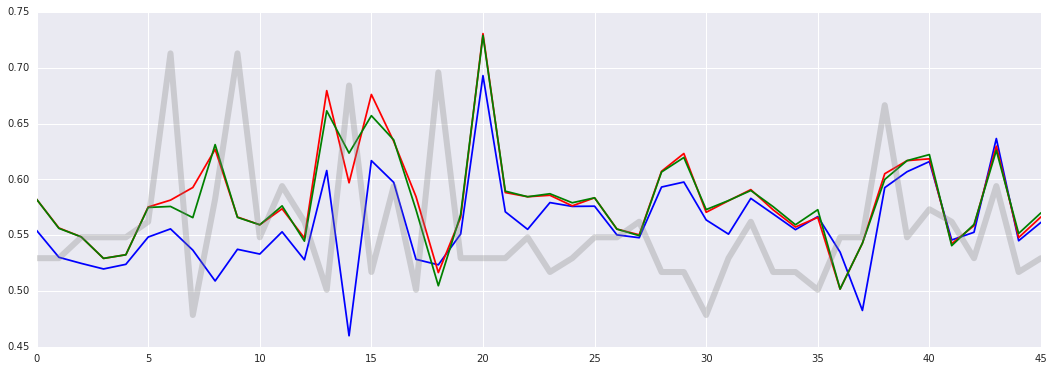

In [152]:
plt.plot(jst, c='blue');
plt.plot(eh7, c='red');
plt.plot(opt, c='green');
plt.plot(np.log(np.asarray(optt))/18+.44, c='gray', linewidth=6, alpha=.3);

##### li optimization

In [45]:
my['quarter'] = quarter(my.time)

In [266]:
%%time
name = 'as21'
x, y = my[name].values, (my.upDown*(my.flat_weight if name[0]!='m' else my.vp10_weight)).values
tblocks, times = make_blocks(my.time.values, TIME.lo, TIME.hi)
hblocks, _ = make_blocks(halfYear(times), HALFYEAR.lo, HALFYEAR.hi)

n = 20_000
w = np.random.exponential(size=(n,6))
w /= w.sum(axis=1)[:,np.newaxis]

scores = [cv_ho_scores(hblocks, daily_li(tblocks, x, y, u)) for u in w]
ibest = sorted(range(n), key=lambda i: scores[i][0], reverse=True)

CPU times: user 20min 27s, sys: 0 ns, total: 20min 27s
Wall time: 22min 34s


In [267]:
scores[ibest[0]]

(0.7706532439592769, 0.6073282995438232)

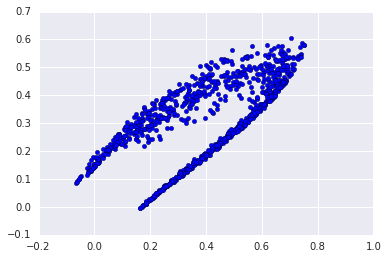

In [268]:
plt.scatter(*zip(*scores[:1000]));

(0.7597013621169011, 0.5651094357900327)

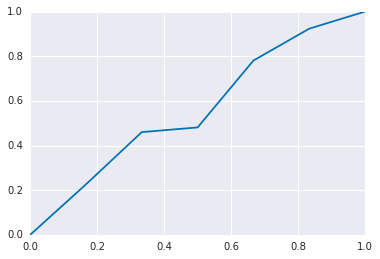

In [281]:
k = 3
display(scores[ibest[k]])
plt.plot(np.linspace(0,1,len(w[k])+1),np.cumsum([0]+list(w[k])));

In [217]:
u

array([ 0.20143572,  0.00130599,  0.06119491,  0.0530886 ,  0.21389272,
        0.20024628,  0.02923615,  0.23959964])

In [220]:
make_joints(u)

array([-1.        , -0.59712857, -0.59451659, -0.47212677, -0.36594958,
        0.06183586,  0.46232842,  0.52080073,  1.        ])

In [218]:
my[name].values

array([-0.12083155, -0.17383294,  0.02165838, ...,  0.01467387,
       -0.00629894,  0.30503811])

In [223]:
linear_isotonic(np.asarray([-0.12]), make_joints(u))

array([ 0.14373419])

In [219]:
linear_isotonic(my[name].values, make_joints(u))

array([ 0.14324823,  0.11227394,  0.22652008, ...,  0.22243829,
        0.21018167,  0.40181446])

In [234]:
check = []
u = w[ibest[k]]
for name in names:
    my['trade'] = linear_isotonic(my[name].values, make_joints(u)) * my.upDown*(my.flat_weight if name[0]!='m' else my.vp10_weight)
    what = my.groupby('time')[['trade']].sum()
    
    what = what.trade
    check.append([cv(what).mean(), ho(what).mean()])
    print(name, check[-1])
check = np.asarray(check)

aikg [0.6901020706314773, 0.5417873252104205]
aIKGZen [0.6806172087087269, 0.5198348428020626]
aIKGHomo [0.6923460950521877, 0.5090438137686978]
aIKGZenTenDraw [0.6866816596716365, 0.49522779960791213]
aIKGHomoTenDraw [0.6970961873482728, 0.491567061950066]
aIKGZenVolatility [0.6808440468797811, 0.5316239642827156]
aIKGHomoVolatility [0.6874631995849817, 0.5358066827358463]
aAnother [0.603073286153064, 0.5503297132211875]
aGlobal [0.6618713514882475, 0.5427199064779247]
aIKGHomoThree [0.6925135362142029, 0.5222964412223522]
aIKGZenThree [0.6920403758465565, 0.515809327118608]
aIKGZenThreeVP1 [0.6932740449159099, 0.5426891156166309]
aIKGZenThreeMoreShort [0.6920856628713982, 0.5130611732236167]
as20 [0.619936573390529, 0.5836287654443176]
as21 [0.6760405572473323, 0.4887405041929184]
as22 [0.6560891784503377, 0.6490911190477426]
as00 [0.6938856208116119, 0.5981876782552716]
as10 [0.6733875313696205, 0.5049828204460663]
as11 [0.6690546545818692, 0.5084261646069029]
aIKGCover [0.692568041

# old data vis

In [39]:
my['daily'] = my.time.map(my.groupby('time').trade.sum())

In [92]:
dl = my.groupby('time')[['trade']].sum()

In [49]:
dailies = sorted(my.daily.unique())

In [66]:
len(dailies)

2014

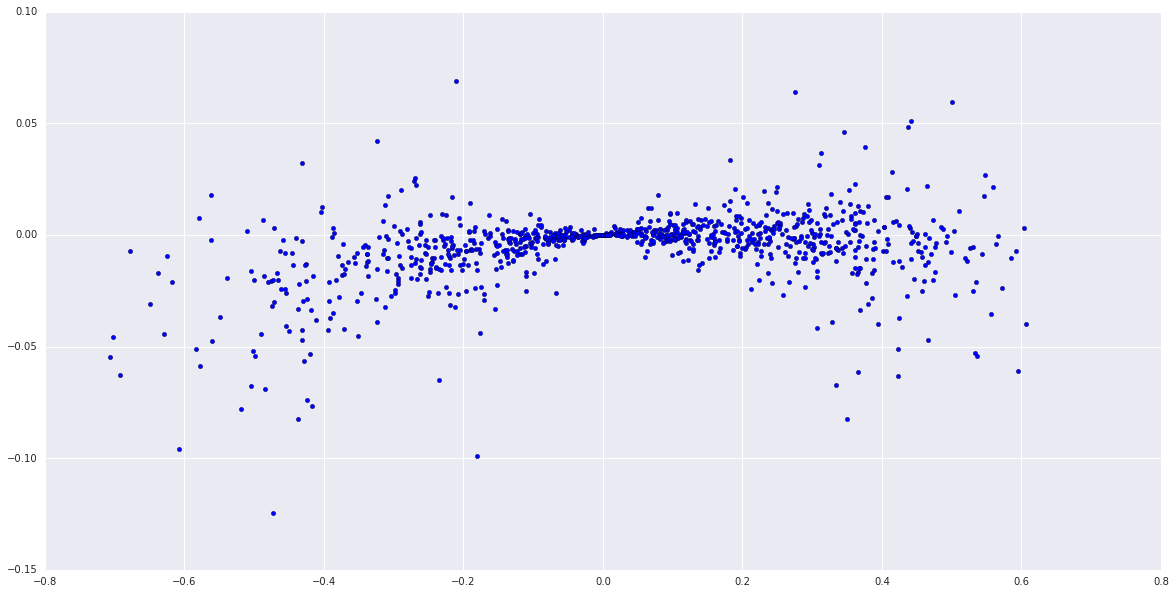

In [141]:
aday = my[my.daily==dailies[1]]
plt.scatter(aday.guess, aday.trade);

In [93]:
dl['guessSum'] = my.groupby('time').guess.sum()
dl['Count'] = my.groupby('time').guess.count()

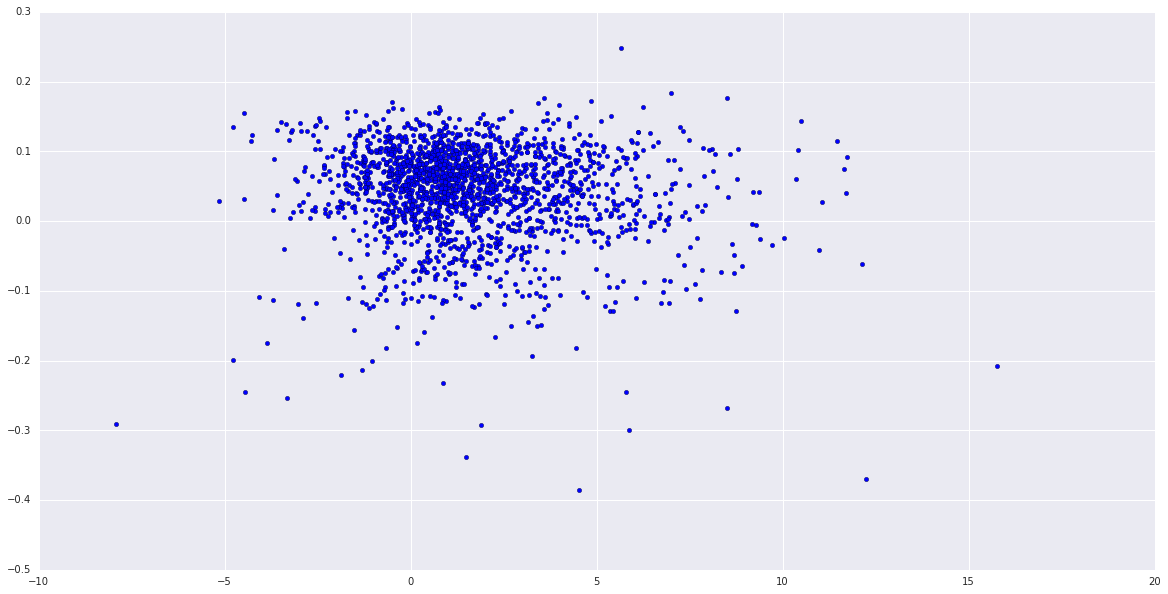

In [98]:
plt.scatter(dl.trade,dl.guessSum/dl.Count);

# COPY PRODUCTION

In [56]:
d.columns

Index(['aikg', 'aIKGZen', 'aIKGHomo', 'aIKGZenTenDraw', 'aIKGHomoTenDraw',
       'aIKGZenVolatility', 'aIKGHomoVolatility', 'aAnother', 'aGlobal',
       'aIKGHomoThree', 'aIKGZenThree', 'aIKGZenThreeVP1',
       'aIKGZenThreeMoreShort', 'as20', 'as21', 'as22', 'as00', 'as10', 'as11',
       'aIKGCover', 'aTryIt', 'aIKGCoverThreeVP1', 'aIKGCoverThreeMoreShort'],
      dtype='object')

In [162]:
def copy_production(names, nbests):
    nl = '\\n'
    for name, nbest in zip(names, nbests):
        ctor = getattr(TP, name[1:])
        if name[0] != 'p': # single
            paramsUse = dict(learning_rate=0.05,max_depth=-1,num_leaves=4096,min_data_in_leaf=120,
                             min_sum_hessian_in_leaf=100,lambda_l1=0,lambda_l2=0)
            features = f'features = {stringify_list(bigF.query_solo(ctor)[0])}'
        else:
            paramsUse = dict(learning_rate=0.05,max_depth=-1,num_leaves=4096,min_data_in_leaf=120,
                             min_sum_hessian_in_leaf=10,lambda_l1=0,lambda_l2=0)
            _f = bigF.query_solo(ctor)[0]
            features = '\n        '.join(x+'_features = '+stringify_list(a) for x,a in zip(['copy','diff','plus','corr'],_f))
        paramsUse.update({'num_iterations': nbest})
        tag = 'vp10' if name[0]=='m' else 'flat'
        guy = f'''\
    class {name}(NamedO()):
        {features}
        feats_ctor = {repr(ctor)}
        train_on = fullhouse
        weight = '{tag}_weight'
        params = {str(O(paramsUse)).replace('<>','dict').replace(' ','')}
            '''
        print(guy[:guy.rindex('\n')])

In [165]:
copy_production(names, nbests)

    class aikg(NamedO()):
        features = ["volume","cc","oo","acc","aoo","ccTEN","ooTEN","accTEN","aooTEN","oo5","oo10","oo15","aoo5","aoo10","aoo15","(aoo-acc)","oo20","oo(10-5)","oo(15-10)","oo(20-15)","oo(15-5)","oo(20-10)","oo(20-5)","aoo20","aoo(10-5)","aoo(15-10)","aoo(20-15)","aoo(15-5)","aoo(20-10)","aoo(20-5)","oo1Since21","oo1MaxSince21","oo1Drawdown1Since21","oo1Drawdown5Since21","oo1Drawdown10Since21","oo1MaxSince21{10}","oo1MinSince21","oo1MinSince21{10}","aoo1Since21","aoo1MaxSince21","aoo1Drawdown1Since21","aoo1Drawdown5Since21","aoo1Drawdown10Since21","aoo1MaxSince21{10}","aoo1MinSince21","aoo1MinSince21{10}","oo1Since62","oo1MaxSince62","oo1Drawdown1Since62","oo1Drawdown5Since62","oo1Drawdown10Since62","oo1MaxSince62{10}","oo1MinSince62","oo1MinSince62{10}","aoo1Since62","aoo1MaxSince62","aoo1Drawdown1Since62","aoo1Drawdown5Since62","aoo1Drawdown10Since62","aoo1MaxSince62{10}","aoo1MinSince62","aoo1MinSince62{10}","oo1Since125","oo1MaxSince125","oo1Drawdown1Since12

    class aIKGHomoTenDraw(NamedO()):
        features = ["cc","oo","acc","aoo","oo5","oo10","oo15","aoo5","aoo10","aoo15","oo(10-5)","oo(15-10)","oo(20-15)","oo(15-5)","oo(20-10)","oo(20-5)","aoo(10-5)","aoo(15-10)","aoo(20-15)","aoo(15-5)","aoo(20-10)","aoo(20-5)","oo1Since21","oo1MaxSince21","oo1Drawdown1Since21","oo1Drawdown5Since21","oo1Drawdown10Since21","oo1MinSince21","oo1MinSince21{10}","aoo1Since21","aoo1MaxSince21","aoo1Drawdown1Since21","aoo1Drawdown5Since21","aoo1Drawdown10Since21","aoo1MinSince21","aoo1MinSince21{10}","oo10Since21","oo10MaxSince21","oo10Drawdown1Since21","oo10Drawdown5Since21","oo10Drawdown10Since21","oo10MinSince21","oo10MinSince21{10}","aoo10Since21","aoo10MaxSince21","aoo10Drawdown1Since21","aoo10Drawdown5Since21","aoo10Drawdown10Since21","aoo10MinSince21","aoo10MinSince21{10}","oo1Since62","oo1MaxSince62","oo1Drawdown1Since62","oo1Drawdown5Since62","oo1Drawdown10Since62","oo1MinSince62","oo1MinSince62{10}","aoo1Since62","aoo1MaxSince62","aoo1Drawdown1S

    class aAnother(NamedO()):
        features = ["oo","aoo","dayOfYear","dayOfWeek","oo15","oo3","oo6","oo9","oo12","oo18","aoo15","aoo3","aoo6","aoo9","aoo12","aoo18","oo{0/1}","oo{0/2}","oo{1/2}","oo{1}","oo{2}","(oo-aoo){0/1}","(oo-aoo){0/2}","(oo-aoo){1/2}","(oo-aoo){1}","(oo-aoo){2}","(oo-cc){0/1}","(oo-cc){0/2}","(oo-cc){1/2}","(oo-cc){1}","(oo-cc){2}","(aoo-acc){0/1}","(aoo-acc){0/2}","(aoo-acc){1/2}","(aoo-acc){1}","(aoo-acc){2}","vp1dd{0/1}","vp1dd{0/2}","vp1dd{1/2}","vp1dd","vp1dd{1}","vp1dd{2}","oo1Since21","oo1MaxSince21","oo1Drawdown5Since21","oo1Drawdown(10-5)Since21","oo1Drawdown(20-10)Since21","oo1MaxSince21{10}","oo1MinSince21","oo1Drawup5Since21","oo1Drawup(10-5)Since21","oo1Drawup(20-10)Since21","oo1MinSince21{10}","aoo1Since21","aoo1MaxSince21","aoo1Drawdown5Since21","aoo1Drawdown(10-5)Since21","aoo1Drawdown(20-10)Since21","aoo1MaxSince21{10}","aoo1MinSince21","aoo1Drawup5Since21","aoo1Drawup(10-5)Since21","aoo1Drawup(20-10)Since21","aoo1MinSince21{10}","vp1dd1Sinc

    class aIKGHomoThree(NamedO()):
        features = ["cc","oo","acc","aoo","oo15","oo3","oo6","oo9","oo12","oo18","aoo15","aoo3","aoo6","aoo9","aoo12","aoo18","oo1Since21","oo1MaxSince21","oo1Drawdown1Since21","oo1Drawdown5Since21","oo1Drawdown10Since21","oo1MinSince21","oo1MinSince21{10}","aoo1Since21","aoo1MaxSince21","aoo1Drawdown1Since21","aoo1Drawdown5Since21","aoo1Drawdown10Since21","aoo1MinSince21","aoo1MinSince21{10}","oo1Since62","oo1MaxSince62","oo1Drawdown1Since62","oo1Drawdown5Since62","oo1Drawdown10Since62","oo1MinSince62","oo1MinSince62{10}","aoo1Since62","aoo1MaxSince62","aoo1Drawdown1Since62","aoo1Drawdown5Since62","aoo1Drawdown10Since62","aoo1MinSince62","aoo1MinSince62{10}","oo1Since125","oo1MaxSince125","oo1Drawdown1Since125","oo1Drawdown5Since125","oo1Drawdown10Since125","oo1MinSince125","oo1MinSince125{10}","aoo1Since125","aoo1MaxSince125","aoo1Drawdown1Since125","aoo1Drawdown5Since125","aoo1Drawdown10Since125","aoo1MinSince125","aoo1MinSince125{10}","oo1Since250

    class as20(NamedO()):
        features = ["dayOfYear","oo15","aoo15","vp1dd15","volatility60","vp60","fracRecordedDaysSince21","oo10MaxSince21","oo10Drawdown5Since21","oo10Drawdown10Since21","oo10Drawdown20Since21","oo10MaxSince21{5}","oo10MinSince21","oo10MinSince21{5}","(oo-aoo)10MaxSince21","(oo-aoo)10Drawdown5Since21","(oo-aoo)10Drawdown10Since21","(oo-aoo)10Drawdown20Since21","(oo-aoo)10MaxSince21{5}","(oo-aoo)10MinSince21","(oo-aoo)10MinSince21{5}","oo10MaxSince62","oo10Drawdown5Since62","oo10Drawdown10Since62","oo10Drawdown20Since62","oo10MaxSince62{5}","oo10MinSince62","oo10MinSince62{5}","(oo-aoo)10MaxSince62","(oo-aoo)10Drawdown5Since62","(oo-aoo)10Drawdown10Since62","(oo-aoo)10Drawdown20Since62","(oo-aoo)10MaxSince62{5}","(oo-aoo)10MinSince62","(oo-aoo)10MinSince62{5}","oo10MaxSince250","oo10Drawdown5Since250","oo10Drawdown10Since250","oo10Drawdown20Since250","oo10MaxSince250{5}","oo10MinSince250","oo10MinSince250{5}","(oo-aoo)10MaxSince250","(oo-aoo)10Drawdown5Since250"

    class as10(NamedO()):
        features = ["cc","oo","dayOfYear","dayOfWeek","volatility60","oo{0/1}","oo{1/2}","oo{1}","oo{2}","(cc-acc){0/1}","(cc-acc){1/2}","(cc-acc){1}","(cc-acc){2}","oo1Since21","oo1MaxSince21","oo1Drawdown1Since21","oo1Drawdown5Since21","oo1Drawdown10Since21","oo1Drawdown(10-5)Since21","oo1MinSince21","oo1MinSince21{5}","oo10Since21","oo10MaxSince21","oo10Drawdown1Since21","oo10Drawdown5Since21","oo10Drawdown10Since21","oo10Drawdown(10-5)Since21","oo10MinSince21","oo10MinSince21{5}","(oo-aoo)10Since21","(oo-aoo)10MaxSince21","(oo-aoo)10Drawdown1Since21","(oo-aoo)10Drawdown5Since21","(oo-aoo)10Drawdown10Since21","(oo-aoo)10Drawdown(10-5)Since21","(oo-aoo)10MinSince21","(oo-aoo)10MinSince21{5}","vp1dd1Since21","vp1dd1MaxSince21{5}","vp1dd1Drawup(20-10)Since21","vp1dd1MinSince21{20}","vp5dd1Since21","vp5dd1MaxSince21{5}","vp5dd1Drawup(20-10)Since21","vp5dd1MinSince21{20}","vp10dd1Since21","vp10dd1MaxSince21{5}","vp10dd1Drawup(20-10)Since21","vp10dd1MinSince21{20

    class aTryIt(NamedO()):
        features = ["oo","aoo","dayOfYear","dayOfWeek","vp10","oo5","oo10","oo15","aoo5","aoo10","aoo15","vp1dd5","vp1dd10","vp1dd15","volatility60","vp20","oo(10-5)","oo(15-10)","oo(20-15)","oo(15-5)","oo(20-10)","oo(20-5)","aoo(10-5)","aoo(15-10)","aoo(20-15)","aoo(15-5)","aoo(20-10)","aoo(20-5)","vp1dd(10-5)","vp1dd(15-10)","vp1dd(20-15)","vp1dd(15-5)","vp1dd(20-10)","vp1dd(20-5)","oo{1}","oo{2}","(oo-aoo){1}","(oo-aoo){2}","(oo-cc){1}","(oo-cc){2}","(aoo-acc){1}","(aoo-acc){2}","vp1dd","vp1dd{1}","vp1dd{2}","fracRecordedDaysSince21","oo1Since21","oo1Drawdown5Since21","oo1Drawdown10Since21","oo1Drawdown20Since21","oo1Drawdown(10-5)Since21","oo1Drawdown(20-10)Since21","oo1MinSince21","aoo1Since21","aoo1Drawdown5Since21","aoo1Drawdown10Since21","aoo1Drawdown20Since21","aoo1Drawdown(10-5)Since21","aoo1Drawdown(20-10)Since21","aoo1MinSince21","oo10Since21","oo10Drawdown5Since21","oo10Drawdown10Since21","oo10Drawdown20Since21","oo10Drawdown(10-5)Since21","oo10

    class aIKGCoverThreeMoreShort(NamedO()):
        features = ["assetCodeId","volume","cc","oo","acc","aoo","oo15","oo3","oo6","oo9","oo12","oo18","aoo15","aoo3","aoo6","aoo9","aoo12","aoo18","af","it","rr","oo{0/1}","oo{0/2}","oo{1/2}","oo{1}","oo{2}","(aoo-acc){0/1}","(aoo-acc){0/2}","(aoo-acc){1/2}","(aoo-acc){1}","(aoo-acc){2}","af{1}","it{1}","(it,af,it{1},aoo,acc){0/1}","(it{1},af{1},it{2},aoo{1},acc{1}){0/1}","(it,af,it{1},aoo,acc){0/2}","(it{1},af{1},it{2},aoo{1},acc{1}){0/2}","(it,af,it{1},aoo,acc){0/3}","(it{1},af{1},it{2},aoo{1},acc{1}){0/3}","(it,af,it{1},aoo,acc){0/4}","(it{1},af{1},it{2},aoo{1},acc{1}){0/4}","(it,af,it{1},aoo,acc){1/2}","(it{1},af{1},it{2},aoo{1},acc{1}){1/2}","(it,af,it{1},aoo,acc){1/3}","(it{1},af{1},it{2},aoo{1},acc{1}){1/3}","(it,af,it{1},aoo,acc){1/4}","(it{1},af{1},it{2},aoo{1},acc{1}){1/4}","(it,af,it{1},aoo,acc){2/3}","(it{1},af{1},it{2},aoo{1},acc{1}){2/3}","(it,af,it{1},aoo,acc){2/4}","(it{1},af{1},it{2},aoo{1},acc{1}){2/4}","oo1Since21","oo1M

    class mIKGZenTenDraw(NamedO()):
        features = ["cc","oo","acc","aoo","oo5","oo10","oo15","aoo5","aoo10","aoo15","oo(10-5)","oo(15-10)","oo(20-15)","oo(15-5)","oo(20-10)","oo(20-5)","aoo(10-5)","aoo(15-10)","aoo(20-15)","aoo(15-5)","aoo(20-10)","aoo(20-5)","oo1Since21","oo1MaxSince21","oo1Drawdown1Since21","oo1Drawdown5Since21","oo1Drawdown10Since21","oo1MinSince21","oo1MinSince21{10}","aoo1Since21","aoo1MaxSince21","aoo1Drawdown1Since21","aoo1Drawdown5Since21","aoo1Drawdown10Since21","aoo1MinSince21","aoo1MinSince21{10}","oo10Since21","oo10MaxSince21","oo10Drawdown1Since21","oo10Drawdown5Since21","oo10Drawdown10Since21","oo10MinSince21","oo10MinSince21{10}","aoo10Since21","aoo10MaxSince21","aoo10Drawdown1Since21","aoo10Drawdown5Since21","aoo10Drawdown10Since21","aoo10MinSince21","aoo10MinSince21{10}","oo1Since62","oo1MaxSince62","oo1Drawdown1Since62","oo1Drawdown5Since62","oo1Drawdown10Since62","oo1MinSince62","oo1MinSince62{10}","aoo1Since62","aoo1MaxSince62","aoo1Drawdown1Si

    class mIKGHomoVolatility(NamedO()):
        features = ["cc","oo","acc","aoo","oo5","oo10","oo15","aoo5","aoo10","aoo15","volatility60","oo(10-5)","oo(15-10)","oo(20-15)","oo(15-5)","oo(20-10)","oo(20-5)","aoo(10-5)","aoo(15-10)","aoo(20-15)","aoo(15-5)","aoo(20-10)","aoo(20-5)","oo1Since21","oo1MaxSince21","oo1Drawdown1Since21","oo1Drawdown5Since21","oo1Drawdown10Since21","oo1MinSince21","oo1MinSince21{10}","aoo1Since21","aoo1MaxSince21","aoo1Drawdown1Since21","aoo1Drawdown5Since21","aoo1Drawdown10Since21","aoo1MinSince21","aoo1MinSince21{10}","volatility20MaxSince21","volatility20MaxSince21{10}","volatility20MinSince21","volatility20MinSince21{10}","oo1Since62","oo1MaxSince62","oo1Drawdown1Since62","oo1Drawdown5Since62","oo1Drawdown10Since62","oo1MinSince62","oo1MinSince62{10}","aoo1Since62","aoo1MaxSince62","aoo1Drawdown1Since62","aoo1Drawdown5Since62","aoo1Drawdown10Since62","aoo1MinSince62","aoo1MinSince62{10}","oo1Since125","oo1MaxSince125","oo1Drawdown1Since125","oo1Drawdown

    class mIKGHomoThree(NamedO()):
        features = ["cc","oo","acc","aoo","oo15","oo3","oo6","oo9","oo12","oo18","aoo15","aoo3","aoo6","aoo9","aoo12","aoo18","oo1Since21","oo1MaxSince21","oo1Drawdown1Since21","oo1Drawdown5Since21","oo1Drawdown10Since21","oo1MinSince21","oo1MinSince21{10}","aoo1Since21","aoo1MaxSince21","aoo1Drawdown1Since21","aoo1Drawdown5Since21","aoo1Drawdown10Since21","aoo1MinSince21","aoo1MinSince21{10}","oo1Since62","oo1MaxSince62","oo1Drawdown1Since62","oo1Drawdown5Since62","oo1Drawdown10Since62","oo1MinSince62","oo1MinSince62{10}","aoo1Since62","aoo1MaxSince62","aoo1Drawdown1Since62","aoo1Drawdown5Since62","aoo1Drawdown10Since62","aoo1MinSince62","aoo1MinSince62{10}","oo1Since125","oo1MaxSince125","oo1Drawdown1Since125","oo1Drawdown5Since125","oo1Drawdown10Since125","oo1MinSince125","oo1MinSince125{10}","aoo1Since125","aoo1MaxSince125","aoo1Drawdown1Since125","aoo1Drawdown5Since125","aoo1Drawdown10Since125","aoo1MinSince125","aoo1MinSince125{10}","oo1Since250

    class ms20(NamedO()):
        features = ["dayOfYear","oo15","aoo15","vp1dd15","volatility60","vp60","fracRecordedDaysSince21","oo10MaxSince21","oo10Drawdown5Since21","oo10Drawdown10Since21","oo10Drawdown20Since21","oo10MaxSince21{5}","oo10MinSince21","oo10MinSince21{5}","(oo-aoo)10MaxSince21","(oo-aoo)10Drawdown5Since21","(oo-aoo)10Drawdown10Since21","(oo-aoo)10Drawdown20Since21","(oo-aoo)10MaxSince21{5}","(oo-aoo)10MinSince21","(oo-aoo)10MinSince21{5}","oo10MaxSince62","oo10Drawdown5Since62","oo10Drawdown10Since62","oo10Drawdown20Since62","oo10MaxSince62{5}","oo10MinSince62","oo10MinSince62{5}","(oo-aoo)10MaxSince62","(oo-aoo)10Drawdown5Since62","(oo-aoo)10Drawdown10Since62","(oo-aoo)10Drawdown20Since62","(oo-aoo)10MaxSince62{5}","(oo-aoo)10MinSince62","(oo-aoo)10MinSince62{5}","oo10MaxSince250","oo10Drawdown5Since250","oo10Drawdown10Since250","oo10Drawdown20Since250","oo10MaxSince250{5}","oo10MinSince250","oo10MinSince250{5}","(oo-aoo)10MaxSince250","(oo-aoo)10Drawdown5Since250"

    class ms10(NamedO()):
        features = ["cc","oo","dayOfYear","dayOfWeek","volatility60","oo{0/1}","oo{1/2}","oo{1}","oo{2}","(cc-acc){0/1}","(cc-acc){1/2}","(cc-acc){1}","(cc-acc){2}","oo1Since21","oo1MaxSince21","oo1Drawdown1Since21","oo1Drawdown5Since21","oo1Drawdown10Since21","oo1Drawdown(10-5)Since21","oo1MinSince21","oo1MinSince21{5}","oo10Since21","oo10MaxSince21","oo10Drawdown1Since21","oo10Drawdown5Since21","oo10Drawdown10Since21","oo10Drawdown(10-5)Since21","oo10MinSince21","oo10MinSince21{5}","(oo-aoo)10Since21","(oo-aoo)10MaxSince21","(oo-aoo)10Drawdown1Since21","(oo-aoo)10Drawdown5Since21","(oo-aoo)10Drawdown10Since21","(oo-aoo)10Drawdown(10-5)Since21","(oo-aoo)10MinSince21","(oo-aoo)10MinSince21{5}","vp1dd1Since21","vp1dd1MaxSince21{5}","vp1dd1Drawup(20-10)Since21","vp1dd1MinSince21{20}","vp5dd1Since21","vp5dd1MaxSince21{5}","vp5dd1Drawup(20-10)Since21","vp5dd1MinSince21{20}","vp10dd1Since21","vp10dd1MaxSince21{5}","vp10dd1Drawup(20-10)Since21","vp10dd1MinSince21{20

    class mTryIt(NamedO()):
        features = ["oo","aoo","dayOfYear","dayOfWeek","vp10","oo5","oo10","oo15","aoo5","aoo10","aoo15","vp1dd5","vp1dd10","vp1dd15","volatility60","vp20","oo(10-5)","oo(15-10)","oo(20-15)","oo(15-5)","oo(20-10)","oo(20-5)","aoo(10-5)","aoo(15-10)","aoo(20-15)","aoo(15-5)","aoo(20-10)","aoo(20-5)","vp1dd(10-5)","vp1dd(15-10)","vp1dd(20-15)","vp1dd(15-5)","vp1dd(20-10)","vp1dd(20-5)","oo{1}","oo{2}","(oo-aoo){1}","(oo-aoo){2}","(oo-cc){1}","(oo-cc){2}","(aoo-acc){1}","(aoo-acc){2}","vp1dd","vp1dd{1}","vp1dd{2}","fracRecordedDaysSince21","oo1Since21","oo1Drawdown5Since21","oo1Drawdown10Since21","oo1Drawdown20Since21","oo1Drawdown(10-5)Since21","oo1Drawdown(20-10)Since21","oo1MinSince21","aoo1Since21","aoo1Drawdown5Since21","aoo1Drawdown10Since21","aoo1Drawdown20Since21","aoo1Drawdown(10-5)Since21","aoo1Drawdown(20-10)Since21","aoo1MinSince21","oo10Since21","oo10Drawdown5Since21","oo10Drawdown10Since21","oo10Drawdown20Since21","oo10Drawdown(10-5)Since21","oo10

    class mIKGCoverThreeMoreShort(NamedO()):
        features = ["assetCodeId","volume","cc","oo","acc","aoo","oo15","oo3","oo6","oo9","oo12","oo18","aoo15","aoo3","aoo6","aoo9","aoo12","aoo18","af","it","rr","oo{0/1}","oo{0/2}","oo{1/2}","oo{1}","oo{2}","(aoo-acc){0/1}","(aoo-acc){0/2}","(aoo-acc){1/2}","(aoo-acc){1}","(aoo-acc){2}","af{1}","it{1}","(it,af,it{1},aoo,acc){0/1}","(it{1},af{1},it{2},aoo{1},acc{1}){0/1}","(it,af,it{1},aoo,acc){0/2}","(it{1},af{1},it{2},aoo{1},acc{1}){0/2}","(it,af,it{1},aoo,acc){0/3}","(it{1},af{1},it{2},aoo{1},acc{1}){0/3}","(it,af,it{1},aoo,acc){0/4}","(it{1},af{1},it{2},aoo{1},acc{1}){0/4}","(it,af,it{1},aoo,acc){1/2}","(it{1},af{1},it{2},aoo{1},acc{1}){1/2}","(it,af,it{1},aoo,acc){1/3}","(it{1},af{1},it{2},aoo{1},acc{1}){1/3}","(it,af,it{1},aoo,acc){1/4}","(it{1},af{1},it{2},aoo{1},acc{1}){1/4}","(it,af,it{1},aoo,acc){2/3}","(it{1},af{1},it{2},aoo{1},acc{1}){2/3}","(it,af,it{1},aoo,acc){2/4}","(it{1},af{1},it{2},aoo{1},acc{1}){2/4}","oo1Since21","oo1M

# scratch

In [29]:
pZing = '''
    <>~Market & (
        <>Return{.&pure&~digit&~TEN} & ~Since & Return{.&
            <>(oo|cc|doo)
            & index[0,1,2, 0:1,1:2]
          }
        | (
            <>Return{(oo{.&[1:]}|aoo[1:]|oo{.&[10:]})}
            & (
                <> ~Drawdown&~Drawup&~Since{Min}&~Since{Max}
                | Drawdown[10:,20:]
                | Since{Min&index[20]}
              )
            & Since[21:, 250:]
          )
        | (
            <>Return{dd} & VP[1:, 10:]
            & (
                | Since{Max & index[0]}
                | Drawup[20:,20:10]
                | Since{Min & index[0]}
              )
            & Since[ 62:, 250:]
          )
      )
    | Market{.&
        <>( Weight)
        & (Return| Volatility)
        & [5:]
      }
    |
        <>Return{pure&~dd} & VP[60:]
        | FracRec[62:]
    |
        | Return{rr| af}
#<>#
    <>~Market & (
        <>Return{.&pure&~digit&~TEN} & ~Since & Return{.&
            <>(oo|cc|daoc)
            & index[0,1,2, 0:1,1:2,0:2]
          }
        | Return{.&pure&~index} & ~Since & Return{.&
            <>(oo)
            & [18:,9:6,15:12,18:15,12:6,18:12,15:6,18:6,21:9,18:3]
          }
      )
#<>#
0
#<>#
    <>0
    | Corr & Corr{
        <>[21,62]
        & (aoo|aooTEN)
      }
'''

In [33]:
copy = bigF.query_solo(pZing.split('#<>#')[0])[0]
diff = bigF.query_solo(pZing.split('#<>#')[1])[0]
plus = bigF.query_solo(pZing.split('#<>#')[2])[0]
corr = '__corr__aoo_21 __corr__aoo_62 __corr__aooTEN_21 __corr__aooTEN_62'.split()

In [41]:
/print stringify_list(plus)

[""]


In [35]:
/print repr(pZing)

'\n    <>~Market & (\n        <>Return{.&pure&~digit&~TEN} & ~Since & Return{.&\n            <>(oo|cc|doo)\n            & index[0,1,2, 0:1,1:2]\n          }\n        | (\n            <>Return{(oo{.&[1:]}|aoo[1:]|oo{.&[10:]})}\n            & (\n                <> ~Drawdown&~Drawup&~Since{Min}&~Since{Max}\n                | Drawdown[10:,20:]\n                | Since{Min&index[20]}\n              )\n            & Since[21:, 250:]\n          )\n        | (\n            <>Return{dd} & VP[1:, 10:]\n            & (\n                | Since{Max & index[0]}\n                | Drawup[20:,20:10]\n                | Since{Min & index[0]}\n              )\n            & Since[ 62:, 250:]\n          )\n      )\n    | Market{.&\n        <>( Weight)\n        & (Return| Volatility)\n        & [5:]\n      }\n    |\n        <>Return{pure&~dd} & VP[60:]\n        | FracRec[62:]\n    |\n        | Return{rr| af}\n#<>#\n    <>~Market & (\n        <>Return{.&pure&~digit&~TEN} & ~Since & Return{.&\n            <

In [309]:
pZing==TP.SearchedPair

False

In [354]:
guys[0,1] # only the FOUR

0.63703449615890917

In [401]:
guys[0,1] # only the FOUR *2

0.63822294856166173

# look at some correlations

In [62]:
my['y'] = (my.target*2-1)*my.flat_weight
my['quarter'] = quarter(my.time)

In [37]:
M = get_M()
set_basic_features(M=M, delete=False)
M['y'] = M.returnsOpenNextMktres10
M['quarter'] = quarter(M.time)

In [51]:
M['vp'] = M.volume * M.open
M['m'] = M.vp.rolling(10).mean()
M['my'] = M.m * M.y

In [52]:
m = M[2009.<=M.quarter].groupby('time')[['y','my']].sum()
m['quarter'] = quarter(m.index)

<IPython.core.display.Javascript object>


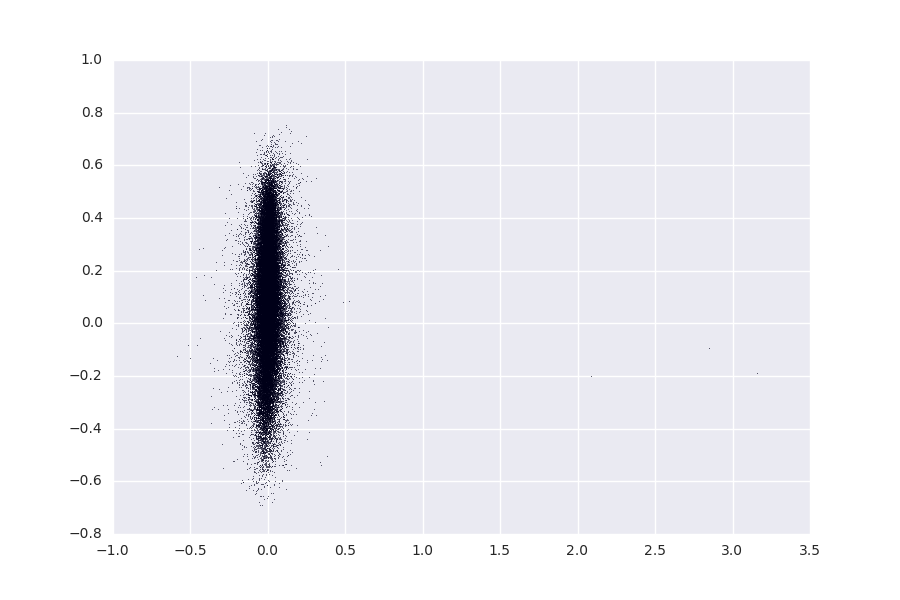

In [64]:
plt.scatter(my[my.quarter==2014].y, my[my.quarter==2014].aikg, s=.1);

In [44]:
F, P = pd.read_pickle(big_data/'saves/train_5fixedsince+2.32.pkl')
setup_P(F=F,P=P)

In [56]:
ee = pd.concat([e, F.groupby(P.time)[['m_oo1','m_oo10','wVPm_oo1','wVPm_oo10']].first()], axis=1)

<IPython.core.display.Javascript object>


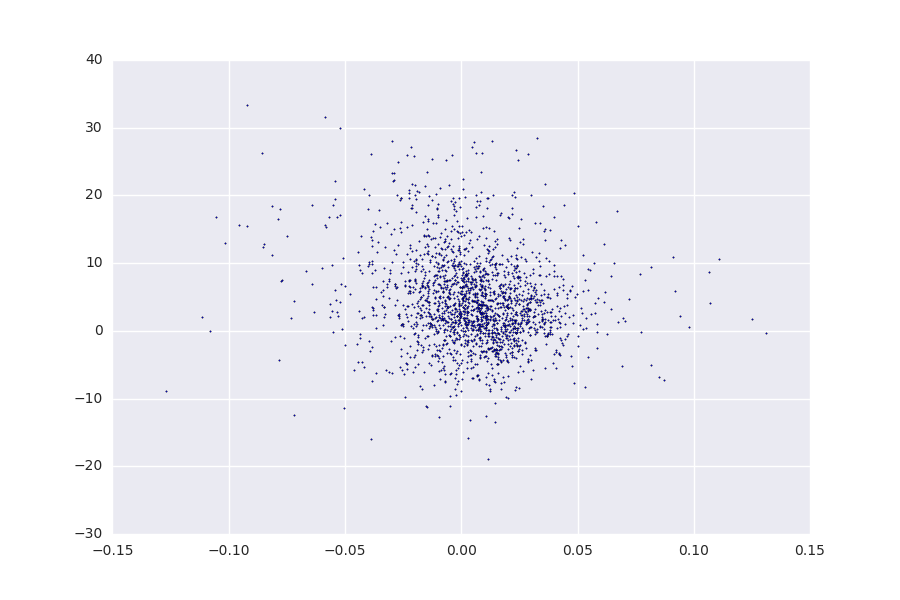

In [61]:
plt.scatter(ee.m_oo10, ee.aTryIt, s=1);

# Super scratch

In [38]:
/print TP.TryIt

<TryIt>
    <>~Market & (
        <>Return{.&pure&~digit&~TEN} & ~Since & Return{.&
            <>(oo|aoo|doo|doc|daoc|vp1dd)
            & index[0,1,2]
          }
        | Return{.&pure&~index} & ~Since & Return{.&
            <>(oo|aoo|vp1dd)
            & [5:,10:,15:,10:5,15:10,20:15,15:5,20:10,20:5]
          }
        | (
            <>Return{(oo{.&[1:]}|aoo[1:]|oo{.&[10:]}|aoo[10:])}
            & (
                <> ~Drawdown&~Drawup&~Since{Min}&~Since{Max}
                | Drawdown[5:,10:,20:, 10:5,20:10]
                | Since{Min&index[0]}
              )
            & Since[21:,125:,250:]
          )
        | (
            <> Volatility[60:]
            | Volatility[20:]
            & (
                | Drawdown[20:]
                | Since{Max & index[0,20]}
                | Drawup[1:, 20:10]
              )
            & Since[21:,125:,250:]
          )
      )
    |
        <>Return{pure&~dd} & VP[10:,20:]
        | FracRec[21:,125:,250:]
    |
        <>AssetEnc{